# Loading and Displaying Well Log Data from LAS

**Created by:** Andy McDonald  
  
This notebook illustrates how to load data in from a LAS file and carry out a basic QC of the data before plotting it on a log plot.

## Loading and Checking Data
The first step is to import the required libraries: pandas, matplotlib and LASIO.  
lasio is a library that has been developed to handle and work with LAS files. More info on the library can be found at: https://lasio.readthedocs.io/en/latest/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lasio

%matplotlib inline 
#%matplotlib qt 

To load our file in, we can use the read() method from LASIO like so:

In [2]:
las = lasio.read("FCIEN/NO_09_B_X1 - BELEN/NO_09_B_X1 - Logs/NO_09_B_X1 - Caliper.las")

Now that our file has been loaded, we can start investigating it's contents.  
To find information out about where the file originated from, such as the well name, location and what the depth range of the file covers, we can create a simple for loop to go over each header item. Using Python's f-string we can join the items together.

In [3]:
for item in las.well:
    print(f"{item.descr} ({item.mnemonic}): {item.value}")

START DEPTH (STRT): 1591.1
STOP DEPTH (STOP): 2155.75
STEP LENGTH (STEP): 0.05
NO VALUE (NULL): -999.25
COMPANY (COMP): ANCAP
WELL (WELL): NO9.B.X-1
FIELD (FLD): BELEN
LOCATION (LOC): BELEN
PROVINCE (PROV): ARTIGAS
STATE (STAT): URUGUAY
EASTING (EAST): 318426.43
NORTHING (NORTH): 6587561.14
PROJECTION NAME (PROJN): YACARE (URUGUAY)
PROJECTION (PROJT): TRANSVERSE MERCATOR
ELIPSOID (ELIP): INTERNATIONAL 1924
CENTRAL MERIDIAN (CMER): 55° 48' 0.0" W
LATITUDE OF ORIGIN (LATOR): 0° 0' 0.0" N
FALSE NORTHING (FNORT): 10002288
FALSE EASTING (FEAST): 500000
SCALE FACTOR (SFACT): 1
SERVICE COMPANY (SRVC): SCHLUMBERGER
LOGDATE (DATE): 2-MAR-87


In [4]:
for item in las.well:
    print(f"{item.descr} ({item.mnemonic}): {item.value}")

START DEPTH (STRT): 1591.1
STOP DEPTH (STOP): 2155.75
STEP LENGTH (STEP): 0.05
NO VALUE (NULL): -999.25
COMPANY (COMP): ANCAP
WELL (WELL): NO9.B.X-1
FIELD (FLD): BELEN
LOCATION (LOC): BELEN
PROVINCE (PROV): ARTIGAS
STATE (STAT): URUGUAY
EASTING (EAST): 318426.43
NORTHING (NORTH): 6587561.14
PROJECTION NAME (PROJN): YACARE (URUGUAY)
PROJECTION (PROJT): TRANSVERSE MERCATOR
ELIPSOID (ELIP): INTERNATIONAL 1924
CENTRAL MERIDIAN (CMER): 55° 48' 0.0" W
LATITUDE OF ORIGIN (LATOR): 0° 0' 0.0" N
FALSE NORTHING (FNORT): 10002288
FALSE EASTING (FEAST): 500000
SCALE FACTOR (SFACT): 1
SERVICE COMPANY (SRVC): SCHLUMBERGER
LOGDATE (DATE): 2-MAR-87


If we just want to extract the Well Name, we can simply call it by:

In [5]:
las.well.WELL.value

'NO9.B.X-1'

To quickly see what curves are present within the las file we can loop through `las.curves`

In [6]:
for curve in las.curves:
    print(curve.mnemonic)

DEPT
C2
C1


To see what curves are present within the las file, we can repeat the process with the CurveItem object and call upon the `unit` and `descr` functions to get info on the units and the curve's description.
The enumerate function allows us to keep a count of the number of curves that are present within the file. As enumerate returns a 0 on the first loop, we need to 1 to it if we want to include the depth curve.

In [7]:
for count, curve in enumerate(las.curves):
    print(f"Curve: {curve.mnemonic}, Units: {curve.unit}, Description: {curve.descr}")
print(f"There are a total of: {count+1} curves present within this file")

Curve: DEPT, Units: M, Description: 
Curve: C2, Units: IN, Description: CALIPER2
Curve: C1, Units: IN, Description: CALIPER1
There are a total of: 3 curves present within this file


## Creating a Pandas Dataframe
Data loaded in using LASIO can be converted to a pandas dataframe using the .df() function. This allows us to easily plot data and pass it into one of the many machine learning algorithms.

In [8]:
well = las.df()

The `.head()` function generates a table view of the header and the first 5 rows within the dataframe.

In [9]:
well.head()

,C2,C1
DEPT,,
1591.10,9.8124,11.1527
1591.15,9.8278,11.1447
1591.20,9.8432,11.1368
1591.25,9.8586,11.1303
1591.30,9.8740,11.1375


To find out more information about data, we can call upon the `.info()` and `.describe()` functions.  
    
The `.info()` function provides information about the data types and how many non-null values are present within each curve.  
The `.describe()` function, provides statistical information about each curve and can be a useful QC for each curve.

In [10]:
well.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 11294 entries, 1591.1 to 2155.75
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   C2      11292 non-null  float64
 1   C1      11294 non-null  float64
dtypes: float64(2)
memory usage: 264.7 KB


## Visualising Data Extent

Instead of the summary provided by the pandas describe() function, we can create a visualisation using matplotlib. Firstly, we need to work out where we have nulls (nan values). We can do this by creating a second dataframe and calling .notnull() on our well dataframe.  
  
As this returns a boolean (True or False) for each depth, we need to multiply by 1 to convert the values from True and False to 1 and 0 respectively.

In [11]:
well_nan = well.notnull() * 1

In [12]:
well_nan.head()

,C2,C1
DEPT,,
1591.10,1,1
1591.15,1,1
1591.20,1,1
1591.25,1,1
1591.30,1,1


We can now create a summary plot of the missing data

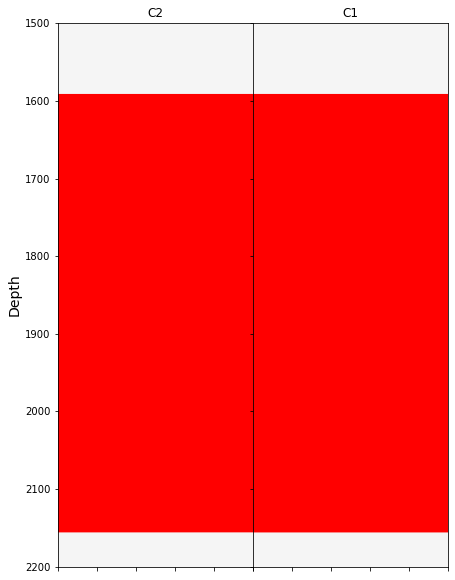

In [13]:
fig = plt.subplots(figsize=(7,10))

#Set up the plot axes
ax1 = plt.subplot2grid((1,2), (0,0), rowspan=1, colspan = 1) 
ax2 = plt.subplot2grid((1,2), (0,1), rowspan=1, colspan = 1)

columns = well_nan.columns
axes = [ax1, ax2]

for i, ax in enumerate(axes):
    ax.plot(well_nan.iloc[:,i], well_nan.index, lw=0)
    ax.set_ylim(2200, 1500)
    ax.set_xlim(0, 1)
    ax.set_title(columns[i])
    ax.set_facecolor('whitesmoke')
    ax.fill_betweenx(well_nan.index, 0, well_nan.iloc[:,i], facecolor='red')
    # Remove tick labels from each subplot
    if i > 0:
        plt.setp(ax.get_yticklabels(), visible = False)
    plt.setp(ax.get_xticklabels(), visible = False)

ax1.set_ylabel('Depth', fontsize=14)

plt.subplots_adjust(wspace=0)
plt.show()

## Plotting Log Data
Finally, we can plot our data using the code below. Essentially, the code is building up a series of subplots and plotting the data on the relevant tracks.  
  
When we add curves to the tracks, we need to set the curve's properties, including the limits, colour and labels. We can also specify the shading between curves. An example has been added to the caliper curve to show shading between a bitsize value (8.5") and the CALI curve.  
  
If there are a number of features that are common between the plots, we can iterate over them using a for loop.

NameError: name 'ax3' is not defined

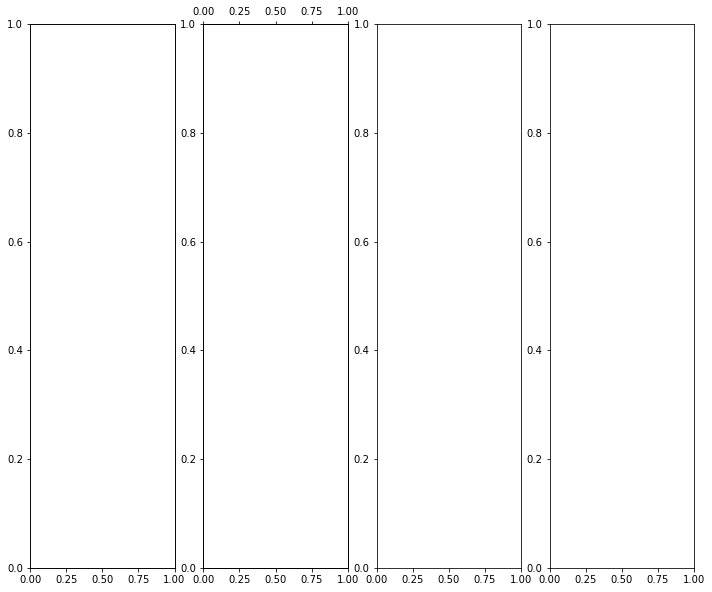

In [14]:
fig, ax = plt.subplots(figsize=(15,10))




# Create a dictionary of formations with a top and bottom depth
formations = {"A":[470, 900], 
              "B": [900, 1370],
              "C": [1370, 1553],
              "D": [1553, 1668],
              "E": [1668, 1778]}

# Select the same number of colours as there are formations
zone_colours = ["red", "blue", "green", "orange", "purple"]









#Set up the plot axes
ax1 = plt.subplot2grid((1,5), (0,0), rowspan=1, colspan = 1)
ax2 = plt.subplot2grid((1,5), (0,1), rowspan=1, colspan = 1, sharey = ax1)
ax5 = plt.subplot2grid((1,5), (0,2), rowspan=1, colspan = 1, sharey = ax1)
ax6 = plt.subplot2grid((1,5), (0,3), rowspan=1, colspan = 1, sharey = ax1)
ax7 = ax2.twiny()

# As our curve scales will be detached from the top of the track,
# this code adds the top border back in without dealing with splines
ax10 = ax1.twiny()
ax10.xaxis.set_visible(False)
ax11 = ax2.twiny()
ax11.xaxis.set_visible(False)
ax12 = ax3.twiny()
ax12.xaxis.set_visible(False)
ax13 = ax4.twiny()
ax13.xaxis.set_visible(False)
ax14 = ax6.twiny()
ax14.xaxis.set_visible(False)


# Caliper track
ax5.plot(well["C1"], well.index, color = "black", linewidth = 0.5)
ax5.set_xlabel("Caliper")
ax5.set_xlim(6, 16)
ax5.xaxis.label.set_color("black")
ax5.tick_params(axis='x', colors="black")
ax5.spines["top"].set_edgecolor("black")
ax5.fill_betweenx(well_nan.index, 8.0, well["C1"], facecolor='yellow')
ax5.set_xticks([6,  11, 16])


# Caliper track
ax6.plot(well["C2"], well.index, color = "black", linewidth = 0.5)
ax6.set_xlabel("Caliper")
ax6.set_xlim(6, 16)
ax6.xaxis.label.set_color("black")
ax6.tick_params(axis='x', colors="black")
ax6.spines["top"].set_edgecolor("black")
ax6.fill_betweenx(well_nan.index, 8.0, well["C2"], facecolor='yellow')
ax6.set_xticks([6,  11, 16])



# Common functions for setting up the plot can be extracted into
# a for loop. This saves repeating code.
for ax in [ax1, ax2, ax4, ax6]:
    ax.set_ylim(2400, 500)
    ax.grid(which='major', color='lightgrey', linestyle='-')
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    ax.spines["top"].set_position(("axes", 1.02))
    
    # loop through the formations dictionary and zone colours
    for depth, colour in zip(formations.values(), zone_colours):
        # use the depths and colours to shade across the subplots
        ax.axhspan(depth[0], depth[1], color=colour, alpha=0.1)
    
    
    
for ax in [ax2, ax5, ax6]:
    plt.setp(ax.get_yticklabels(), visible = False)
    
plt.tight_layout()
fig.subplots_adjust(wspace = 0.15)
plt.show()

In [ ]:
well['LITH'].describe()

In [74]:
well['FM'] = 0

well['FM'][(well.index > 470) & (well.index <= 900)] = 'TACUAREMBO'
well['FM'][(well.index > 900) & (well.index <= 1370)] = 'BUENA VISTA'
well.head()

<ipython-input-74-fe8b71b24afc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  well['FM'][(well.index > 470) & (well.index <= 900)] = 'TACUAREMBO'
<ipython-input-74-fe8b71b24afc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  well['FM'][(well.index > 900) & (well.index <= 1370)] = 'BUENA VISTA'


,ILD,ILM,SFLU,SP,DT,GR,CALI,RHOB,DRHO,PEF,...,POTA,SGR,CGR,W5NG,W4NG,W3NG,W2NG,W1NG,CS,FM
DEPT:2,,,,,,,,,,,,,,,,,,,,,
2364.943,2000.0,1191.000,748.000,-41.030,51.188,-1882.0,8.469,2.691,0.017,2.686,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2364.791,2000.0,1738.019,539.873,-40.650,51.188,-1882.0,8.469,2.723,0.031,2.586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2364.638,2000.0,1999.629,493.815,-40.218,51.188,-1882.0,8.469,2.738,0.034,2.713,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2364.486,2000.0,1856.151,662.323,-39.731,51.188,-1882.0,8.469,2.722,0.021,2.730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2364.334,2000.0,1922.954,595.046,-39.299,51.188,-1882.0,8.469,2.691,0.009,2.910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [53]:
well.to_excel('well.xlsx')